## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [53]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data_test.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (167055, 8)


In [54]:
#dir(crypto.binance_client)
crypto.binance_client.get_account()

{'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1000.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.00000000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '10000.05864000', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'buyerCommission': 0,
 'canDeposit': False,
 'canTrade': True,
 'canWithdraw': False,
 'makerCommission': 0,
 'permissions': ['SPOT'],
 'sellerCommission': 0,
 'takerCommission': 0,
 'updateTime': 1656368336658}

### Generate Candles and build features from technical analysis

In [55]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 1700, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 1700 steps
Generated time-series
Normalized 'candles_norm' with shape : (1700, 9)
Feature data 'x_candles' with size : 1652
Feature data with time intervals 'x_time' with size : 1652


In [56]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

In [57]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

199

,Close,Pred Close
Date,,
2022-06-10 18:01:00,29102.77,28640.386125
2022-06-10 18:16:00,29060.47,28605.015561
2022-06-10 18:31:00,28992.77,28575.180035
2022-06-10 18:46:00,29056.80,28549.622626
2022-06-10 19:01:00,29047.92,28534.719592
...,...,...
2022-06-27 21:31:00,20829.62,20942.561876
2022-06-27 21:46:00,20803.24,20942.421127
2022-06-27 22:01:00,20879.26,20942.493138


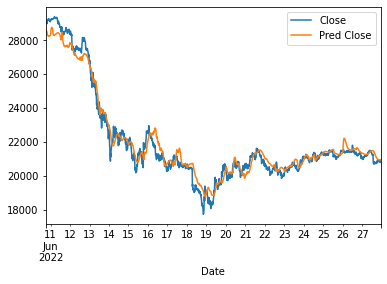

In [88]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

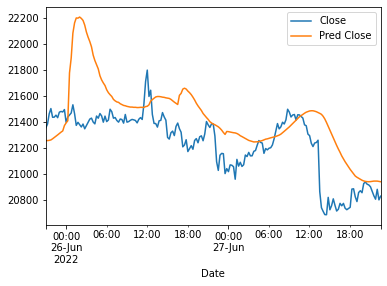

In [89]:
df_preds_true.dropna().iloc[-new_time_steps:].plot()

Fee: 0.025
----------------------
Buy      180 ( 92 ok 88 ko )
Avg PCT gain: 1.0021523002519117
Avg PCT loss: 0.9982167446141825
Wins  PCT   0.5111111111111111
Avg PCT Gain.    1.0021523002519117
No-op    0
Wallet   663.6835000000017
Drawback -389.27449999999885
Kelly Fraction    0.02414213940687182
Total earned 663.6835000000017


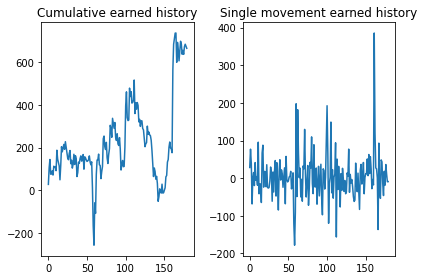

In [91]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna().iloc[-199:], ts_btc.step_back-30, long_short = "longshort", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

All caught up..!
size of dataset: (169808, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952


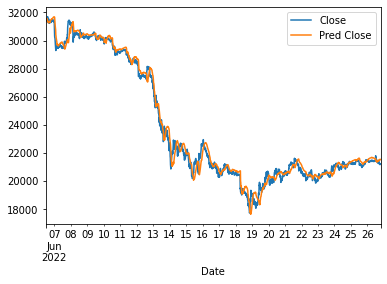

In [ ]:
investment = 100.
conservative_kelly = kelly_frac*.5
portfolio = investment
order_status = "not_filled"

while True:

  ldata_df_new = crypto.load_cryptos(tickers,save = False)
  can_btc = fb.Candles(ldata_df_new,"Bitcoin")
  can_btc.buildfeatures()
  ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = "15m",
                  lownorm = 0.2, upnorm= 0.8)

  ts_btc.candles2ts()
  ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
  ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
  initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
  loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
  loaded_model.sats2model()
  loaded_model.load_model(model_name)
  loaded_model.sats2pred(predict_on_test = False)
  loaded_model.load_scaler(model_name + '/scaler.sav')
  preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
  new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
  df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
  df_preds_true.dropna().iloc[-new_time_steps:].plot()
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)

  prev_true_close = df_preds_true_shifted.iloc[-2,0]
  prev_pred_close = df_preds_true_shifted.iloc[-2,1]
  pred_close = df_preds_true_shifted.iloc[-1,1]

  fee = 0.025

  elapsed_minutes = (pd.Timestamp(datetime.now()) - df_preds_true.index[-1]).seconds/crypto.dt
  time_condition = delta.seconds/crypto.dt -1. < elapsed_minutes <  delta.seconds/crypto.dt + 1.

  if time_condition and order_status == "not_filled" :

    if prev_true_close*(1+fee) < pred_close:

        #get price
        price = crypto.binance_client.get_symbol_ticker(symbol=tickers[0])
        # Calculate how much to buy
        buy_quantity = round(portfolio*conservative_kelly / float(price['price']))
        buy_quantity = 0.001
        order = crypto.binance_client.create_order(symbol=tickers[0],
                                                    side='BUY',
                                                    type='MARKET',
                                                    quantity= buy_quantity)
        
        order_status= "filled"
        






In [ ]:
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)
  df_preds_true_shifted

,Close,Pred Close
Date,,
2017-08-17 06:31:00,NaN,NaN
2017-08-17 06:46:00,NaN,NaN
2017-08-17 07:01:00,NaN,NaN
2017-08-17 07:16:00,NaN,NaN
2017-08-17 07:31:00,NaN,NaN
...,...,...
2022-06-26 18:16:00,21423.38,21523.698347
2022-06-26 18:31:00,21496.15,21526.703175
2022-06-26 18:46:00,21476.19,21513.184720


In [ ]:
df_preds_true

,Close,Pred Close
Date,,
2017-08-17 06:31:00,4345.45,NaN
2017-08-17 06:46:00,4324.35,NaN
2017-08-17 07:01:00,4316.62,NaN
2017-08-17 07:16:00,4291.38,NaN
2017-08-17 07:31:00,4300.00,NaN
...,...,...
2022-06-26 18:16:00,21192.14,21523.698347
2022-06-26 18:31:00,21215.06,21526.703175
2022-06-26 18:46:00,21186.64,21513.184720
